In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import time

In [2]:
def prior_kernel(s,t):
    return np.exp(-(t-s)**2)

In [3]:
class posterior:
    def __init__(self, T, x, y, prior_kernel,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.prior_kernel = prior_kernel
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.sigma = sigma
        self.K = np.fromfunction(np.vectorize(lambda s, t: self.prior_kernel(self.T[s], self.T[t])), (self.g, self.g), dtype=int)
    
    def Lx(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = np.trapz(self.K[t, :] * self.x[i,:], self.T)
        return L
        
    def R(self,i, j):
        Ri = np.trapz(self.K[:, :] * self.x[i, :], self.T, axis=1)
        Rij = np.trapz(Ri * self.x[j, :],self.T)
        return Rij

    def cov(self):
        return np.array([[self.R(i, j) for j in range(self.n)] for i in range(self.n)])
    
    def posterior_mean_cov(self):
        inv = np.linalg.inv(self.cov() + self.sigma * np.identity(self.n))
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx(t)),inv),self.y)
            return mean
        def Kstar(s,t):
            cov = self.K[s,t] - np.dot(np.dot(np.transpose(self.Lx(s)),inv),self.Lx(t))
            return cov
        
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        C = np.fromfunction(np.vectorize(lambda t, s: Kstar(s,t)), (self.g,self.g), dtype=int)
        return m,C
    
    def only_mean(self):
        inv = np.linalg.inv(self.cov() + self.sigma * np.identity(self.n))        
        def m(t):
            mean = np.dot(np.dot(np.transpose(self.Lx(t)),inv),self.y)
            return mean
        m = np.fromfunction(np.vectorize(lambda t: m(t)), (self.g,), dtype=int)
        return m
    
    def fitted_values(self):
        m = self.only_mean()
        return np.fromfunction(np.vectorize(lambda i: np.trapz(self.x[i,:]*m,self.T)), (self.n,), dtype=int)

# Regular Smoothing

In [4]:
sigma = 10
T = np.linspace(1, 288, 288)

In [5]:
df = pd.read_csv('average_curves.csv', index_col='idx')
df 

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
idx,,,,,,,,,,,,,,,,,,,,,
pat_number,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,150.000000,151.000000,152.000000,153.000000,154.000000,155.000000,156.000000,157.000000,158.000000,159.000000
severity,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
constancy,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
age,58.000000,59.000000,62.000000,65.000000,65.000000,70.000000,66.000000,74.000000,58.000000,74.000000,...,68.000000,49.000000,51.000000,66.000000,45.000000,74.000000,67.000000,59.000000,34.000000,72.000000
gender,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,-0.981659,-1.076615,-1.332550,-1.058805,-0.923807,-1.109480,-1.743754,-1.184359,-1.359995,-1.107242,...,-1.485589,-1.074087,-1.003103,-0.996204,-1.740179,-1.447827,-1.043098,-1.684661,-1.077221,-1.393487
284,-0.993531,-1.078280,-1.332549,-1.044116,-0.923762,-1.109441,-1.743714,-1.217882,-1.360021,-1.116414,...,-1.486356,-1.074077,-1.002612,-0.994606,-1.740226,-1.445859,-1.042748,-1.684662,-1.077203,-1.393533
285,-0.997926,-1.079618,-1.332558,-1.019142,-0.923818,-1.109399,-1.743523,-1.224489,-1.360155,-1.127783,...,-1.487368,-1.074091,-1.003404,-0.994287,-1.740254,-1.440550,-1.042608,-1.684662,-1.077191,-1.393537


In [6]:
x = df.iloc[7:, :].T.to_numpy()
y = df.iloc[1, :].T.to_numpy()

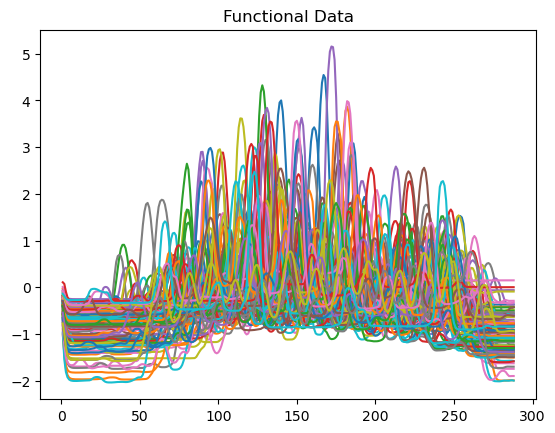

In [7]:
plt.plot(T,x[:100,:].T)
plt.title('Functional Data')
plt.show()

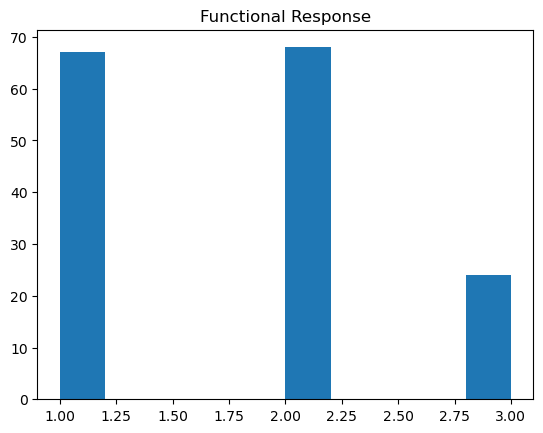

In [8]:
plt.hist(df.iloc[1,:])
plt.title('Functional Response')
plt.show()

In [9]:
y23 = np.copy(y)
y23[y == 1] = 0
y23[y == 2] = 1
y23[y == 3] = 1
np.unique(y23)

array([0., 1.])

In [10]:
model = posterior(T, x, y23, prior_kernel,sigma)

In [11]:
start = time.time()
fitted = model.fitted_values()
(time.time()-start)/60

0.18927876551946005

In [12]:
logit_fitted = scipy.special.expit(fitted)

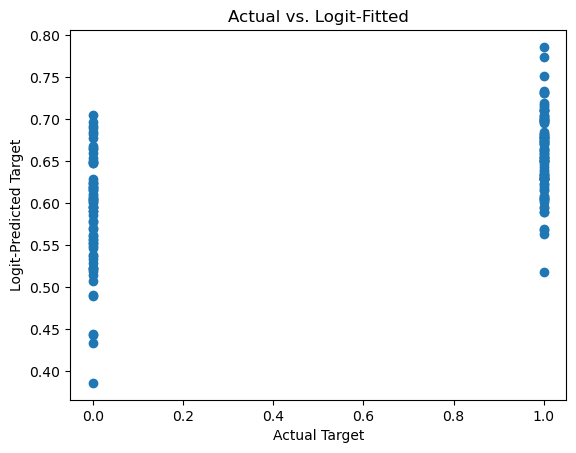

In [13]:
plt.scatter(y23,logit_fitted)
plt.xlabel('Actual Target')
plt.ylabel('Logit-Predicted Target')
plt.title('Actual vs. Logit-Fitted')
plt.show()

In [14]:
labels = np.zeros(len(logit_fitted))
ones= np.where(logit_fitted > 0.5)
labels[ones] = np.ones(len(ones)) 


print('Accuracy with Logit: ' + str(np.sum(labels==y23)/len(y23)))

Accuracy with Logit: 0.6163522012578616


# Aggressive Smoothing

In [15]:
df = pd.read_csv('average_curves_ss.csv', index_col='idx')
df 

,0,1,2,3,4,5,6,7,8,9,...,150,151,152,153,154,155,156,157,158,159
idx,,,,,,,,,,,,,,,,,,,,,
pat_number,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,150.000000,151.000000,152.000000,153.000000,154.000000,155.000000,156.000000,157.000000,158.000000,159.000000
severity,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
constancy,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
age,58.000000,59.000000,62.000000,65.000000,65.000000,70.000000,66.000000,74.000000,58.000000,74.000000,...,68.000000,49.000000,51.000000,66.000000,45.000000,74.000000,67.000000,59.000000,34.000000,72.000000
gender,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0.264180,-0.958538,-0.909707,-0.273826,-0.286432,-0.867684,-1.150715,-0.375622,-0.833306,0.308803,...,-0.842007,-0.582675,-0.466491,-0.245536,-1.290839,-0.994759,-1.043901,-1.348897,-1.984352,-0.821621
284,0.265907,-0.944253,-0.909631,-0.265414,-0.286426,-0.867634,-1.120154,-0.533183,-0.833408,0.314359,...,-0.842338,-0.582566,-0.450976,-0.245475,-1.290406,-0.951263,-1.043798,-1.344007,-1.984351,-0.822633
285,0.270004,-0.919418,-0.909511,-0.256728,-0.286419,-0.867565,-1.070047,-0.697419,-0.833177,0.324483,...,-0.842582,-0.582427,-0.430791,-0.245351,-1.289824,-0.894565,-1.043693,-1.337268,-1.984351,-0.823784


In [16]:
x = df.iloc[7:, :].T.to_numpy()
sigma = 1

y = df.iloc[1, :].T.to_numpy()

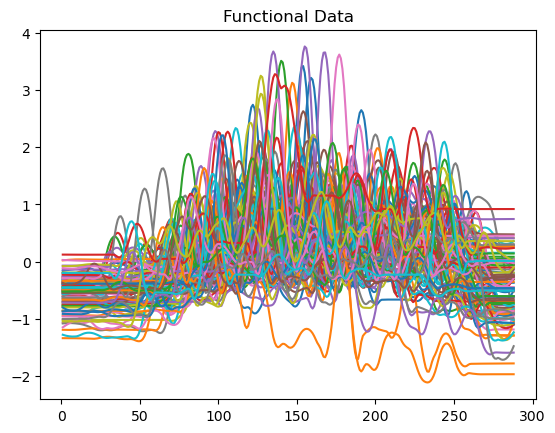

In [17]:
plt.plot(T,x[:100,:].T)
plt.title('Functional Data')
plt.show()

In [18]:
model = posterior(T, x, y23, prior_kernel,sigma)

In [19]:
start = time.time()
fitted = model.fitted_values()
(time.time()-start)/60

0.1598380446434021

In [20]:
logit_fitted = scipy.special.expit(fitted)

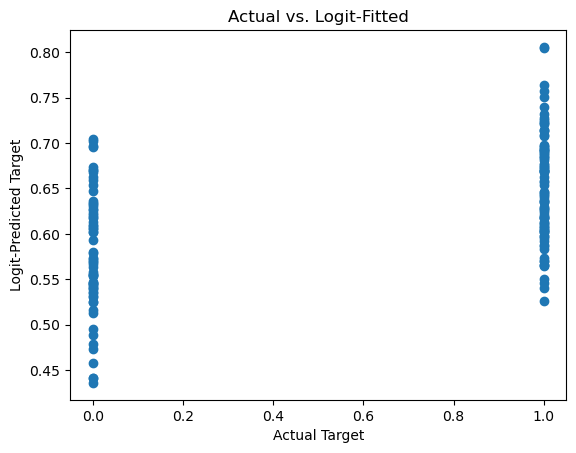

In [21]:
plt.scatter(y23,logit_fitted)
plt.xlabel('Actual Target')
plt.ylabel('Logit-Predicted Target')
plt.title('Actual vs. Logit-Fitted')
plt.show()

In [22]:
labels = np.zeros(len(logit_fitted))
ones= np.where(logit_fitted > 0.5)
labels[ones] = np.ones(len(ones)) 


print('Accuracy with Logit: ' + str(np.sum(labels==y23)/len(y23)))

Accuracy with Logit: 0.6289308176100629


### Test: Align All Curves

In [23]:
import fdasrsf as fs

In [24]:
time = np.arange(x.shape[1]).astype(np.float64)

obj = fs.fdawarp(np.transpose(x), time)
obj.srsf_align(parallel=True)
aligned = obj.fn

Initializing...
Compute Karcher Mean of 159 function in SRSF space with lam=0.000000
updating step: r=1
updating step: r=2
updating step: r=3
updating step: r=4
updating step: r=5
updating step: r=6
updating step: r=7
updating step: r=8
updating step: r=9
updating step: r=10
updating step: r=11
updating step: r=12
updating step: r=13
updating step: r=14
updating step: r=15
updating step: r=16
updating step: r=17
updating step: r=18
updating step: r=19
updating step: r=20
maximal number of iterations is reached


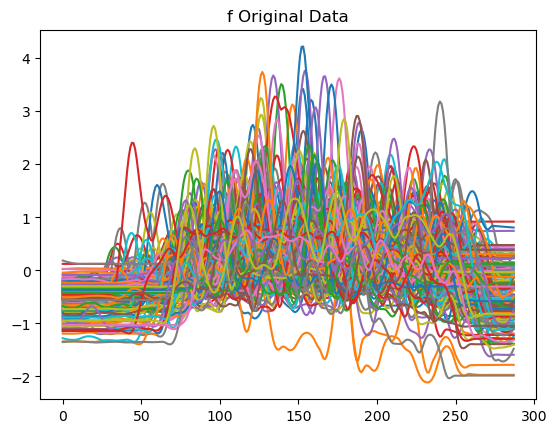

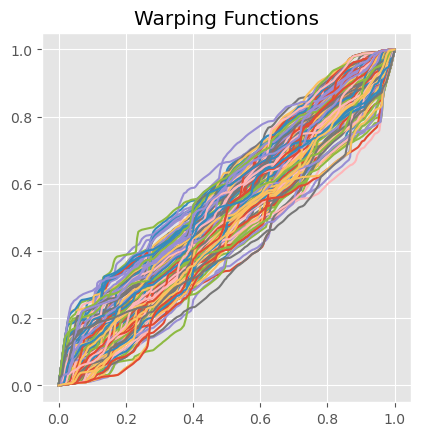

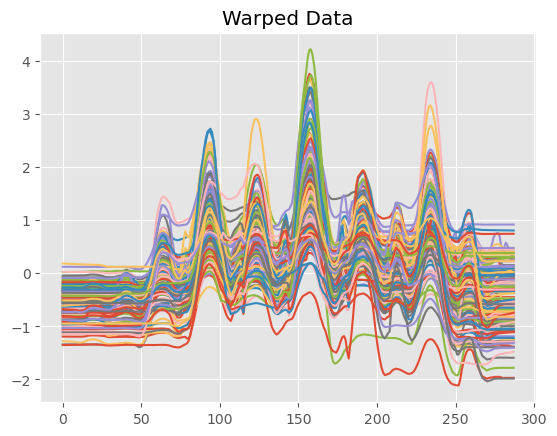

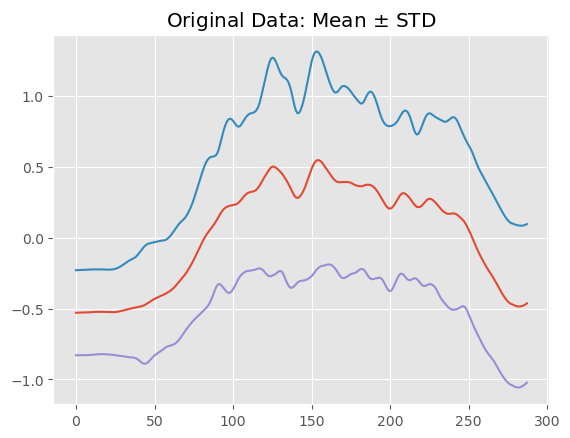

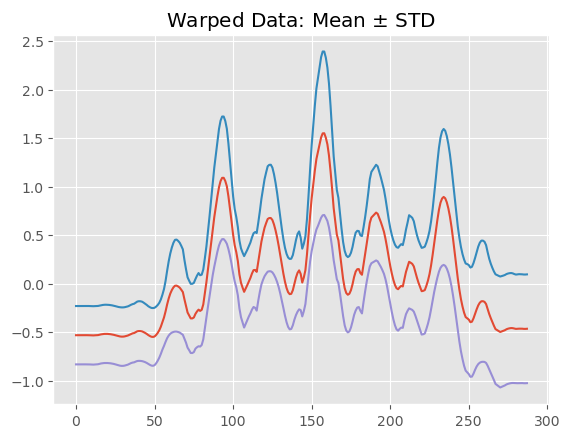

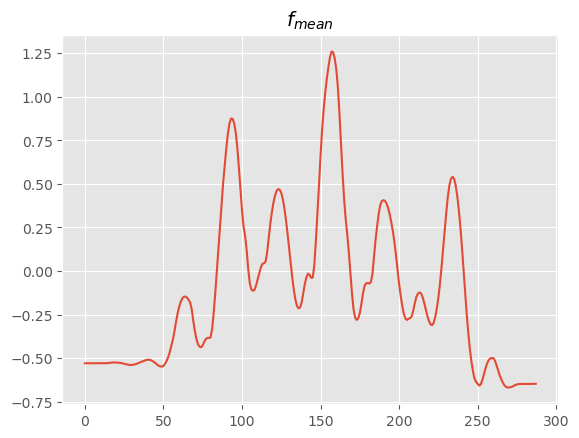

In [25]:
obj.plot()

In [26]:
model = posterior(T, np.transpose(aligned), y23, prior_kernel, sigma)
fitted = model.fitted_values()

In [27]:
logit_fitted = scipy.special.expit(fitted)

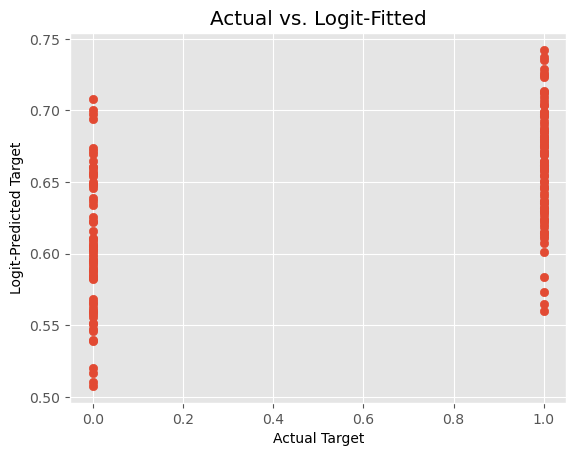

In [28]:
plt.scatter(y23,logit_fitted)
plt.xlabel('Actual Target')
plt.ylabel('Logit-Predicted Target')
plt.title('Actual vs. Logit-Fitted')
plt.show()

In [29]:
labels = np.zeros(len(logit_fitted))
ones= np.where(logit_fitted > 0.5)
labels[ones] = np.ones(len(ones)) 


print('Accuracy with Logit: ' + str(np.sum(labels==y23)/len(y23)))

Accuracy with Logit: 0.5786163522012578
